# Function Approximation with PyTorch

The objective of this tutorial is learn the basics of PyTorch.

To this end, we cosider the task of learning the function

$$u = sin(x), \quad x\in(0, 2\pi)$$

by using feed-forward dense neural networks.

$\mathbf{\text{Step 1: Dataset Generation}}$

We are going to use the training set

$$S=\{ (x_i, u_i), ~i=1,...,n \}$$

with

$$x_i \sim U\big(0, 2\pi\big), \quad u_i \sim N\big(sin(x_i), \sigma(x_i)\big).$$

Here, $U(a,b)$ is a uniform random distribution between $a$ and $b$, and $N(\mu, \sigma)$ is a normal distribution with mean $\mu$ and standard deviation $\sigma$

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Uncomment and complete the following code to generate synthetic sine wave data with added noise
def generate_data(num_points, noise_std=0.1):
    # Generate random x values
    x_values = np.sort(np.random.uniform(0, 2 * np.pi, num_points))
    # Generate corresponding y values for sine curve with added noise
    y_values = np.sin(x_values) + np.random.normal(0, noise_std, num_points)
    return x_values, y_values

num_points = 1000

# You can adjust the noise level as needed
x_train, y_train = generate_data(num_points, noise_std=0.1)

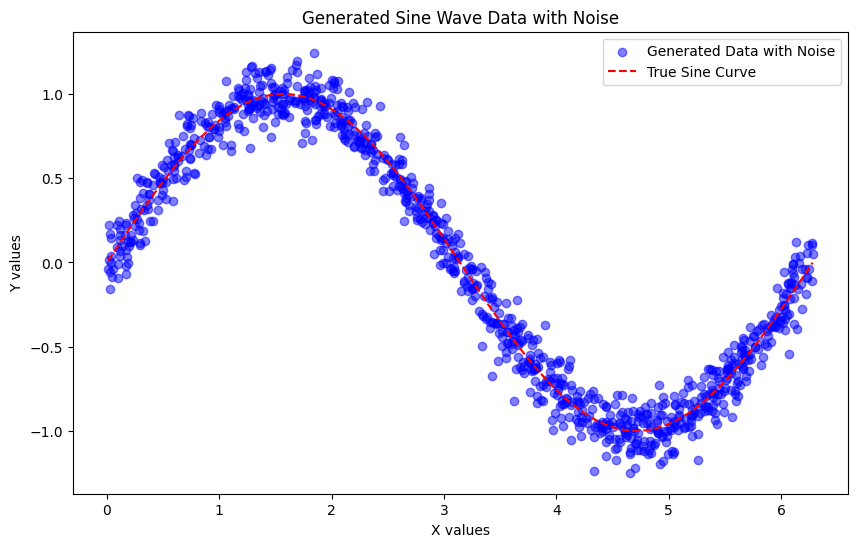

In [ ]:
# Plot the generated data
plt.figure(figsize=(10, 6))

plt.scatter(
    x_train, y_train,
    label='Generated Data with Noise', color='blue', alpha=0.5)
plt.plot(
    x_train, np.sin(x_train),
    label='True Sine Curve', color='red', linestyle='--')

plt.legend()
plt.title('Generated Sine Wave Data with Noise')
plt.xlabel('X values')
plt.ylabel('Y values')
plt.show()

$\mathbf{\text{Step 2: Model Definition}}$

We use feedforward neural (also named as a multi-layer perceptron) network to approximate the function

$$ u = sin(x)$$

Given an input $x \in D \subset R^n$, a feedforward neural network transforms it to an output $u_\theta(x)\in R^m$, through a layer of units (neurons) which compose of either affine-linear maps between units (in successive layers) or scalar non-linear activation functions within units, resulting in the representation,

$$u_{\theta}(x) = C_K \circ A \circ C_{K-1}\ldots \ldots \ldots \circ A\circ C_2 \circ A\circ C_1(x).$$

Here, $\circ$ refers to the composition of functions and $A$ is a scalar (non-linear) activation function. For any $1 \leq k \leq K$, we define

$$
C_k z_k = W_k z_k + b_k, \quad {\rm for} ~ W_k \in R^{d_{k+1} \times d_k}, z_k \in R^{d_k}, b_k \in R^{d_{k+1}}.
$$

We also denote,
$$
\theta = \{W_k, b_k\}, \theta_W = \{ W_k \}\quad \forall~ 1 \leq k \leq K,
$$
to be the complete set of (tunable) weights for our network.


In [ ]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(1, 10)  # 1 input feature, 10 hidden units
        self.activation = nn.SiLU()
        self.fc2 = nn.Linear(10, 1)  # 10 hidden units, 1 output

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

$\mathbf{\text{Step 3: Model Training}}$

The neural network $u_{\theta}$ depends on the tuning parameter $\theta \in \Theta$ of weights and biases. Within the standard paradigm of deep learning, one trains the network by finding tuning parameters $\theta$ such that a suitable loss function $J(\theta)$ is minimized.

$${\rm Find}~\theta^{\ast} \in \Theta:\quad \theta^{\ast} = {\rm arg}\min\limits_{\theta \in \Theta} \left( J(\theta)\right).$$

The loss function, for instance, can be chosen as the mean square error between the neural network and the underlying target:

$$ J(\theta) = \sum_{i}^n \Big(u_i - u_\theta(x_i)\Big)^2$$

The optimization process is realized with the gradient descent (or more precisely with variants of the gradient descent such as Adam or SGD).

1. Compute the loss function over the batch $j$:
$J_S(\theta)=\sum_{x_i \in {S}_j}^n \Big(u_i - u_\theta(x_i)\Big)^2$

2. Compute the gradient of $J_S(\theta)$ with respect to the network parameters:  $\nabla_\theta J_S(\theta)$

3. Update the parameters according to the chosen optimizer, for instance for minibatch stochastic gradient descent $\theta_{k+1} = \theta_{k} - \eta \nabla_\theta J_S(\theta_{k}) $ with $k=1,...,(n_{epoch} n_{batch})$ and $\eta$ being the learning rate (argument $lr$ in the optimizer).

#### **ADAM Optimizer**

Adaptive Momement Estimation: adaptive learning rates for different parameters from estimates of first and second moments of the gradients.
https://arxiv.org/pdf/1412.6980.pdf

#### **LBFGS Optimizer (Generic Idea)**

Let us consider a generic function $f: x\mapsto f(x)$, $x\in R^d$ and $f(x)\in R$. The taylor approximation of $\nabla f$ in a neighbourhood of $x_k$ is

$$\nabla f(x_k + \delta x) = \nabla f(x_k) + H_k\delta x$$

with $H_k$ being the Hessian of $f$ at $x_k$.
We would like to find the vector $ \delta x$ such that

$$\nabla f(x_k + \delta x) = 0$$

This leads to

$$x_{k+1} = x_k - H_k^{-1}\nabla f \quad \text{(Newton Method)}$$

The idea of Quasi-Newton methods (LBFGS belong to this class) is to approximate $H$ with a positive definite matrix $B$, which is easier to compute:

$$x_{k+1} = x_k   - B_{k}^{-1}\nabla f \quad \text{(Quasi - Newton Method)}$$

The matrix B has to satisfy the following conditions:
- Positive definiteness
- $B_k$ and $B_{k+1}$ "sufficiently close"
- Secant equation  $$ B_{k+1}[x_{k+1} - x_k] = \nabla f(x_{k+1}) - \nabla f(x_{k})$$

A constraint minimization problem can be set to find the update formula for $B_k$
(check https://towardsdatascience.com/bfgs-in-a-nutshell-an-introduction-to-quasi-newton-methods-21b0e13ee504)

In [ ]:
def get_optimizer(optimizer_name, model):
  if optimizer_name == "ADAM":
      return optim.Adam(model.parameters())
  elif optimizer_name == "LBFGS":
      return optim.LBFGS(model.parameters())
  raise ValueError('Chosen optimizer is unavailable.')


def train(model, optimizer, criterion, inputs, targets):
    def closure():
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        return loss

    optimizer.step(closure)
    return closure().item()


def evaluate(model, x_test):
    model.eval()
    with torch.no_grad():
        y_pred = model(x_test.view(-1, 1)).numpy()
    return y_pred

#### Instantiate your model, define your loss function + optimizer, and perform the training procedure.

In [ ]:
model = SimpleNN()
criterion = nn.MSELoss()
optimizer = get_optimizer('ADAM', model)

num_epochs = 10000
for epoch in range(num_epochs):
    # Convert data to PyTorch tensors
    inputs = torch.tensor(
        x_train, dtype=torch.float32, requires_grad=True).view(-1, 1)
    targets = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

    # Training
    loss = train(model, optimizer, criterion, inputs, targets)

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}')

Epoch [100/10000], Loss: 0.3434
Epoch [200/10000], Loss: 0.2172
Epoch [300/10000], Loss: 0.1755
Epoch [400/10000], Loss: 0.1614
Epoch [500/10000], Loss: 0.1488
Epoch [600/10000], Loss: 0.1357
Epoch [700/10000], Loss: 0.1228
Epoch [800/10000], Loss: 0.1114
Epoch [900/10000], Loss: 0.1020
Epoch [1000/10000], Loss: 0.0946
Epoch [1100/10000], Loss: 0.0886
Epoch [1200/10000], Loss: 0.0835
Epoch [1300/10000], Loss: 0.0786
Epoch [1400/10000], Loss: 0.0739
Epoch [1500/10000], Loss: 0.0691
Epoch [1600/10000], Loss: 0.0643
Epoch [1700/10000], Loss: 0.0594
Epoch [1800/10000], Loss: 0.0545
Epoch [1900/10000], Loss: 0.0497
Epoch [2000/10000], Loss: 0.0450
Epoch [2100/10000], Loss: 0.0406
Epoch [2200/10000], Loss: 0.0365
Epoch [2300/10000], Loss: 0.0326
Epoch [2400/10000], Loss: 0.0291
Epoch [2500/10000], Loss: 0.0260
Epoch [2600/10000], Loss: 0.0233
Epoch [2700/10000], Loss: 0.0209
Epoch [2800/10000], Loss: 0.0189
Epoch [2900/10000], Loss: 0.0173
Epoch [3000/10000], Loss: 0.0159
Epoch [3100/10000],

$\mathbf{\text{Step 4: Plotting Predictions}}$


Final step, evaluate your predictions at some input locations and do some plotting.


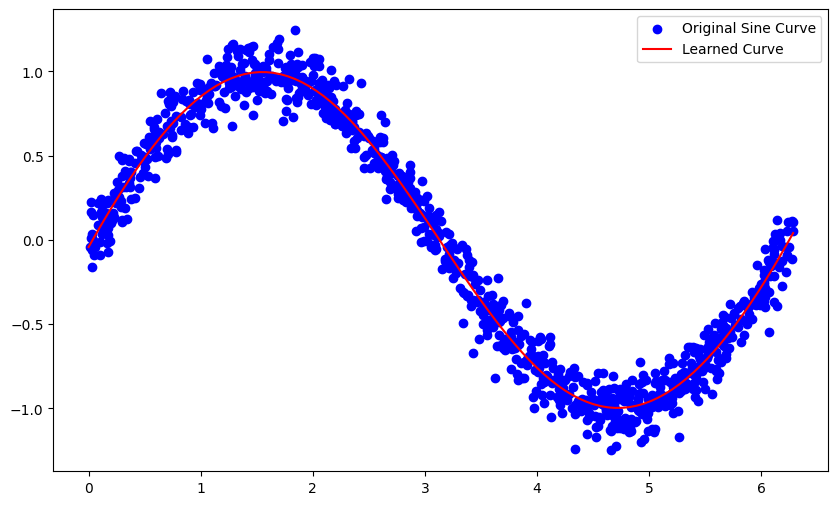

In [ ]:
x_test = torch.linspace(0, 2*np.pi, 100)
y_pred = evaluate(model, x_test)

plt.figure(figsize=(10, 6))
plt.scatter(x_train, y_train, label='Original Sine Curve', color='blue')
plt.plot(x_test, y_pred, label='Learned Curve', color='red')

plt.legend()
plt.show()